# Packages

In [94]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
import seaborn as sns

from plotting import plot_formatter

# Data

In [36]:
data = pd.read_csv('../Data/Covid19_Data.csv', index_col=0, parse_dates=['Date']).set_index('Date')
data= data.loc[data.CountryName.isin(['England', 'France', 'Germany', 'Spain', 'Italy'])]

# Color Dictionary

In [5]:
color_dict = {'England': '#265aff', 
              'France': '#ff4f00', 
              'Germany': '#ffa500', 
              'Spain': '#196F3D',
              'Italy': '#8E44AD'}

# New Cases & Deathes

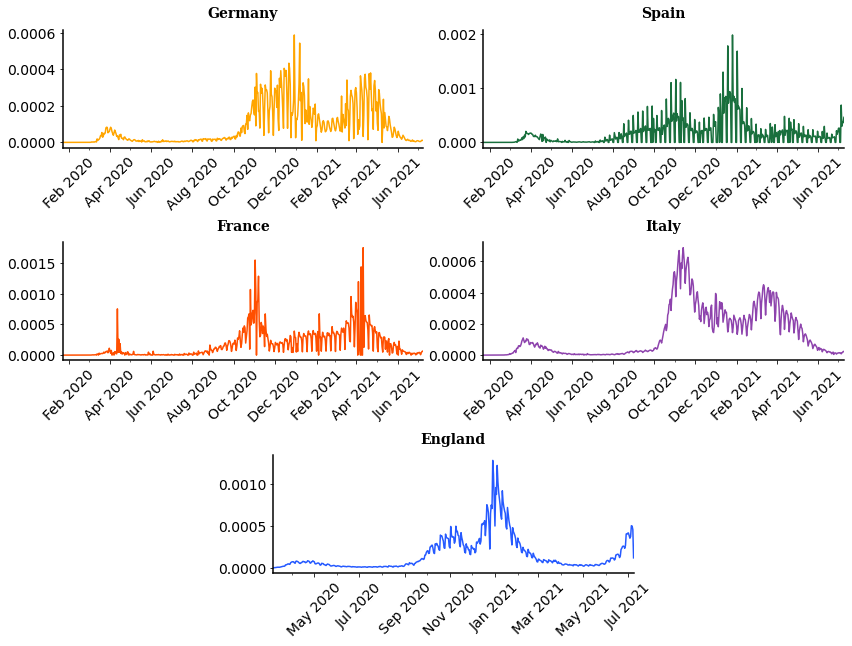

In [99]:
a = data.copy()

a['NewCases_Pop'] = a['NewCases'] / a['Population2020']

fig, axes = plt.subplot_mosaic(
    """
    AABB
    CCDD
    .EE.
    """
    ,
    gridspec_kw = {'wspace': 0.4, 'hspace': 0.8},
    figsize=(14, 10)
)


titles = ['A', 'B', 'C', 'D', 'E']
countries = data.CountryName.unique()
subplots_names = [*axes.keys()]

for i, country in enumerate(unique_countries):
    a.loc[data.CountryName == country, 'NewCases_Pop'].plot(ax=axes[subplots_names[i]], color=color_dict[country])
    h, l = plot_formatter(axes[subplots_names[i]],
                           title=country, xlabel=None, ylabel=None,  
                           rotation=(45, 0), 
                           xlabel_size=12, ylabel_size=18, title_size=14,
                           xtick_size=14, ytick_size=14,
                           xlabel_pad=10, ylabel_pad=10,
                           title_position=(0.5, 1.05),
                           xaxis_lwd=1.5, yaxis_lwd=1.5,
                           xaxis_date=True, date_format='%b %Y', date_month_interval=2,
                           remove_legend=True) 

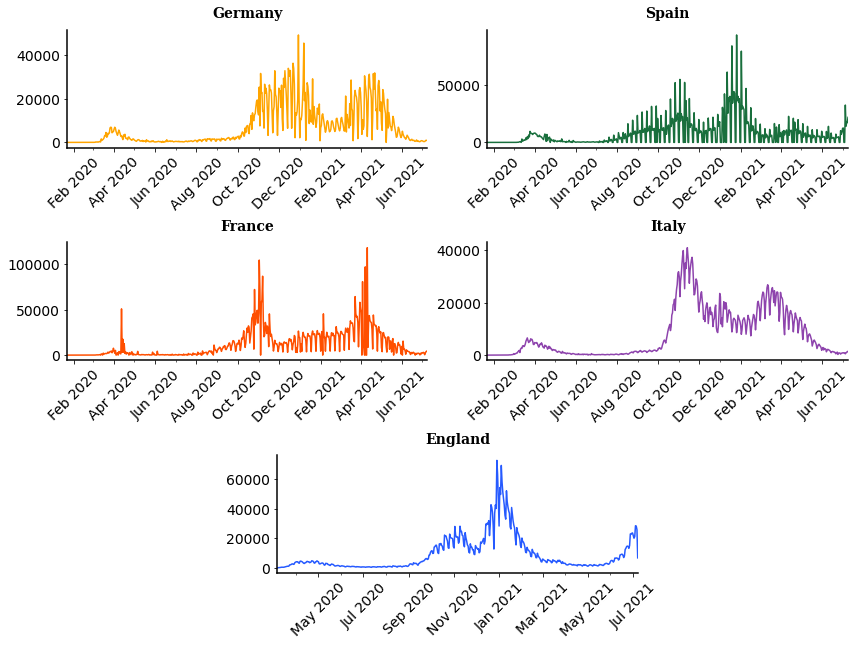

In [93]:
fig, axes = plt.subplot_mosaic(
    """
    AABB
    CCDD
    .EE.
    """
    ,
    gridspec_kw = {'wspace': 0.4, 'hspace': 0.8},
    figsize=(14, 10)
)


titles = ['A', 'B', 'C', 'D', 'E']
countries = data.CountryName.unique()
subplots_names = [*axes.keys()]

for i, country in enumerate(unique_countries):
    data.loc[data.CountryName == country, 'NewCases'].plot(ax=axes[subplots_names[i]], color=color_dict[country])
    h, l = plot_formatter(axes[subplots_names[i]],
                           title=country, xlabel=None, ylabel=None,  
                           rotation=(45, 0), 
                           xlabel_size=12, ylabel_size=18, title_size=14,
                           xtick_size=14, ytick_size=14,
                           xlabel_pad=10, ylabel_pad=10,
                           title_position=(0.5, 1.05),
                           xaxis_lwd=1.5, yaxis_lwd=1.5,
                           xaxis_date=True, date_format='%b %Y', date_month_interval=2,
                           remove_legend=True) 

# 3. Vaccination

In [42]:
def vaccine_df(df, lag, feature='FullyVaccinated', daily=False):
    """
    Makes a relation dataset between daily vaccine at t, and new cases at t+delta_t
    """
    
    vaccine = df[[feature, 'NewCases', 'CountryName']].dropna()
    vaccine.reset_index(drop=False, inplace=True)
    
    if ~daily:
        vaccine['DailyVaccination'] = vaccine.groupby('CountryName')[feature].diff()
    else:
        vaccine.columns = ['DailyVaccination', 'NewCases', 'CountryName']
    
    
    output = pd.concat([vaccine.CountryName,
                        vaccine.NewCases, 
                        vaccine.groupby('CountryName')['DailyVaccination'].shift(periods=lag)], 
                       axis='columns').dropna()
    
    return output

In [43]:
r_df = pd.DataFrame()

for lag in np.arange(0, 71, 5):
    vaccine = vaccine_df(data, lag=lag, feature='FullyVaccinated', daily=False)
    temp = vaccine.groupby('CountryName').\
                        aggregate(lambda x: pearsonr(x.NewCases.values, x.DailyVaccination.values))
    temp['lag'] = lag 
    r_df = pd.concat([r_df, temp], axis='rows')

r_df.columns = ['r', 'pvalue', 'lag']

### 3.1. Effectiveness of Vaccination (linear association)

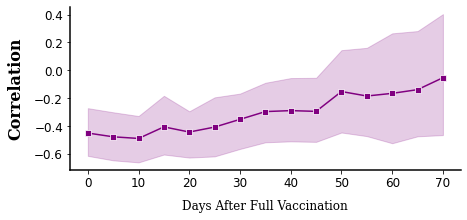

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
sns.lineplot(data=r_df, x='lag', y='r', n_boot=5000, seed=110, color='purple', marker='s')

h, l = plot_formatter(ax, fig,
                       title=None, xlabel='Days After Full Vaccination', ylabel='Correlation',  
                       rotation=(0, 0), 
                       xlabel_size=12, ylabel_size=16, title_size=12,
                       xtick_size=12, ytick_size=12,
                       xlabel_pad=10, ylabel_pad=10,
                       title_position=(0.5, 0.9),
                       xaxis_lwd=1.5, yaxis_lwd=1.5,
                       xaxis_date=False, date_format='%b %Y', date_month_interval=4,
                       remove_legend=False)

### 3.2. Full Vaccination Scatterplot

In [13]:
from scipy.stats import pearsonr

In [14]:
def _asteriks(p_value):
    if p_value <= 1e-4:
        return '****'
    elif p_value <= 1.00e-3:
        return '***'
    elif p_value <= 1.00e-2:
        return '**'
    elif p_value <= 5.00e-2:
        return '*'
    elif p_value <= 1:
        return 'ns'

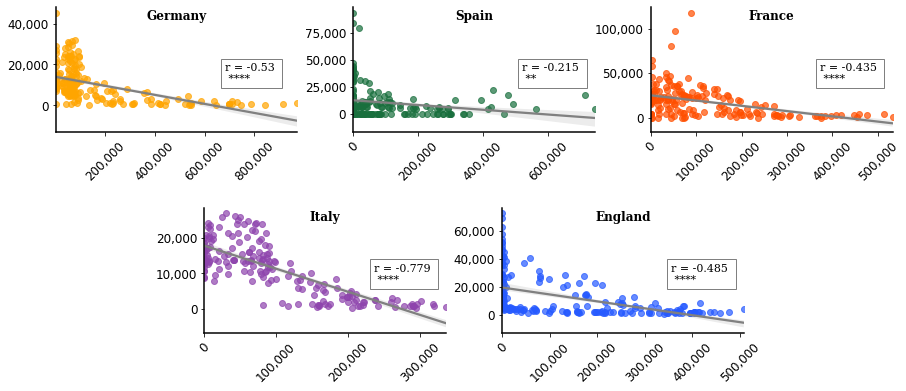

In [46]:
# Create Dataset
vaccine = vaccine_df(data, lag=10, feature='FullyVaccinated', daily=False)
corr_info = vaccine.groupby('CountryName').apply(lambda x: pearsonr(x.NewCases, x.DailyVaccination))
max_values = vaccine.groupby('CountryName').max()


# Layout
fig, axes = plt.subplot_mosaic(
    """
    AABBCC
    .DDEE.
    """
    ,
    gridspec_kw = {'wspace': 0.6, 'hspace': 0.6},
    figsize=(15, 6)
)


unique_countries = data.CountryName.unique()
subplots_names = [*axes.keys()]

# Plot
for i, country in enumerate(unique_countries):
    # plot
    df_new = vaccine.loc[vaccine.CountryName == country]
    ax = axes[subplots_names[i]]
    color = color_dict[country]
    sns.regplot(data=df_new, y='NewCases', x='DailyVaccination', ax=ax, ci=95, n_boot=50, lowess=False,
                line_kws={'color': 'grey'}, scatter_kws={'color': color, 'alpha': 0.7})
    
    r = corr_info[country][0]
    pvalue = _asteriks(corr_info[country][1])
    ax.annotate(f'r = {np.round(r, 3)} \n {pvalue}', size=11, fontfamily='serif', xycoords='axes fraction',
                xy=(0.7, 0.4), bbox=dict(facecolor='none', edgecolor='grey'))

    h, l = plot_formatter(ax, fig,
                           title=country, xlabel=None, ylabel=None,  
                           rotation=(45, 0), 
                           xlabel_size=16, ylabel_size=16, title_size=12,
                           xtick_size=12, ytick_size=12,
                           xlabel_pad=10, ylabel_pad=10,
                           title_position=(0.5, 0.85),
                           xaxis_lwd=1.5, yaxis_lwd=1.5,
                           xaxis_date=False, date_format='%b %Y', date_month_interval=4,
                           show_thousand_x=True, show_thousand_y=True,
                           remove_legend=False)
    
#fig.supxlabel('Fully Vaccinated', size=20, fontweight='bold', fontfamily='serif', y=-0.1)
#fig.supylabel('New Cases', size=30, fontweight='bold', fontfamily='serif', x=0.05)

# Policies

### Closure Policies

In [21]:
closure =  ['C1_School closing',
            'C2_Workplace closing', 'C3_Cancel public events',
            'C4_Restrictions on gatherings', 'C5_Close public transport',
            'C6_Stay at home requirements', 'C7_Restrictions on internal movement',
            'C8_International travel controls']

In [18]:
for policy in closure:
    print(policy, '=>', len(data[policy].unique()))

C1_School closing => 4
C2_Workplace closing => 4
C3_Cancel public events => 3
C4_Restrictions on gatherings => 5
C5_Close public transport => 3
C6_Stay at home requirements => 4
C7_Restrictions on internal movement => 3
C8_International travel controls => 5


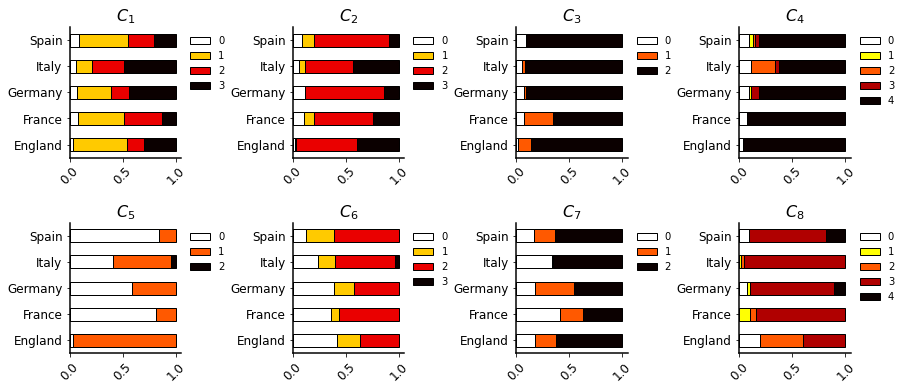

In [91]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
plt.subplots_adjust(hspace=0.5, wspace=1)

titles = [r'$C_{}$'.format(i) for i in range(1, 9)]
ax_num = [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3)]



for i, policy in enumerate(closure):

    temp = data.groupby('CountryName')[policy].\
                    apply(lambda x: pd.value_counts(x, normalize=True)).\
                    reset_index(1)

    temp['level_1'] = temp.level_1.astype('int64')
    cmap = matplotlib.cm.get_cmap(name='hot_r')



    temp.pivot(columns=['level_1']).plot(kind='barh', stacked=True, 
                                         cmap=cmap, 
                                         ax=axes[ax_num[i]], edgecolor='k')

    h, l = plot_formatter(axes[ax_num[i]], fig=None,
                           title=titles[i], xlabel=None, ylabel=None,  
                           rotation=(45, 0), 
                           xlabel_size=12, ylabel_size=20, title_size=16,
                           xtick_size=12, ytick_size=12,
                           xlabel_pad=10, ylabel_pad=10,
                           title_position=(0.5, 1), xlabel_position=None, ylabel_position=None,
                           xaxis_lwd=1.5, yaxis_lwd=1.5,
                           xaxis_date=False, date_format='%b %Y', date_month_interval=1,
                           show_thousand_x=False, show_thousand_y=False,
                           remove_legend=True)


    axes[ax_num[i]].legend(h, range(len(l)), bbox_to_anchor=(1, 1), 
                           loc='upper left', frameon=False)

### Economic

In [18]:
economic =  ['E1_Income support', 'E2_Debt/contract relief']

In [160]:
for policy in economic:
    print(policy, '=>', len(data[policy].unique()))

E1_Income support => 3
E2_Debt/contract relief => 3


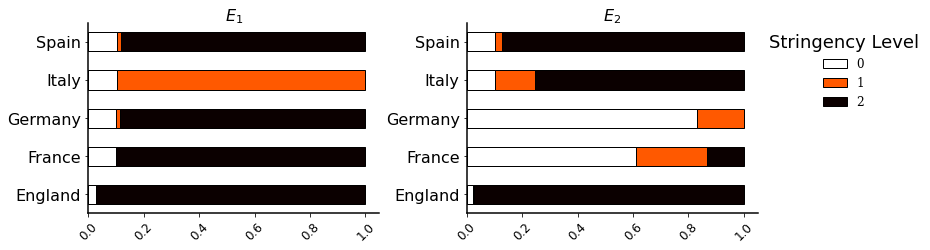

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))
plt.subplots_adjust(wspace=0.3)

titles = [r'$E_{}$'.format(i) for i in range(1, 3)]
ax_num = [0, 1]


for i, policy in enumerate(economic):

    temp = data.groupby('CountryName')[policy].\
                    apply(lambda x: pd.value_counts(x, normalize=True)).\
                    reset_index(1)

    temp['level_1'] = temp.level_1.astype('int64')
    cmap = matplotlib.cm.get_cmap(name='hot_r')



    temp.pivot(columns=['level_1']).plot(kind='barh', stacked=True, 
                                         cmap=cmap, 
                                         ax=axes[ax_num[i]], edgecolor='k')

    h, l = plot_formatter(axes[ax_num[i]], fig=None,
                           title=titles[i], xlabel=None, ylabel=None,  
                           rotation=(45, 0), 
                           xlabel_size=12, ylabel_size=12, title_size=16,
                           xtick_size=12, ytick_size=16,
                           xlabel_pad=10, ylabel_pad=10,
                           title_position=(0.5, 0.98), xlabel_position=None, ylabel_position=None,
                           xaxis_lwd=1.5, yaxis_lwd=1.5,
                           xaxis_date=False, date_format='%b %Y', date_month_interval=1,
                           show_thousand_x=False, show_thousand_y=False,
                           remove_legend=True)


fig.legend(h, [0, 1, 2, 3, 4], bbox_to_anchor=(0.9, 0.88),
           loc='upper left', prop={'size': 12, 'family': 'serif'}, 
           title_fontsize=18, title='Stringency Level', frameon=False)

### Healthcare

In [5]:
healthcare = ['H1_Public information campaigns',
               'H2_Testing policy', 'H3_Contact tracing', 'H6_Facial Coverings',
               'H7_Vaccination policy', 'H8_Protection of elderly people']

In [6]:
for policy in healthcare:
    print(policy, '=>', len(data[policy].unique()))

H1_Public information campaigns => 3
H2_Testing policy => 4
H3_Contact tracing => 3
H6_Facial Coverings => 5
H7_Vaccination policy => 5
H8_Protection of elderly people => 4


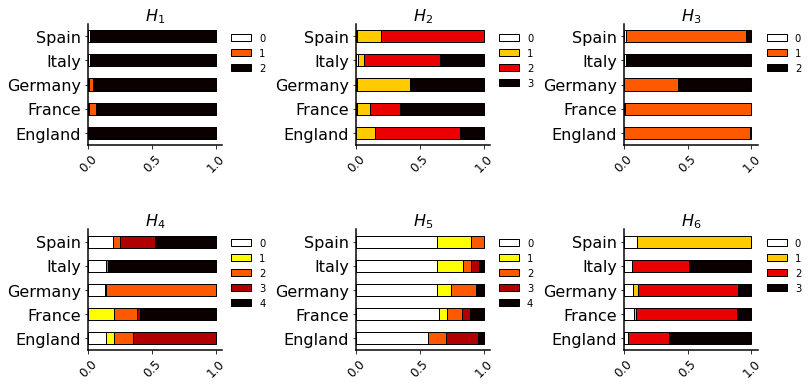

In [88]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
plt.subplots_adjust(wspace=1, hspace=0.7)

titles = [r'$H_{}$'.format(i) for i in range(1, 7)]
ax_num = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
colors = ['white', 'yellow', '#24A2EF', '#DD0B0B', '#271B1B']


for i, policy in enumerate(healthcare):
    
    temp = data.groupby('CountryName')[policy].\
                    apply(lambda x: pd.value_counts(x, normalize=True)).\
                    reset_index(1)

    temp['level_1'] = temp.level_1.astype('int64')
    n_levels = len(temp['level_1'].unique())
    cmap = matplotlib.cm.get_cmap(name='hot_r')



    temp.pivot(columns=['level_1']).plot(kind='barh', stacked=True, 
                                         cmap=cmap,
                                         #color=colors[:n_levels+1], 
                                         ax=axes[ax_num[i]], edgecolor='k')

    h, l = plot_formatter(axes[ax_num[i]], fig=None,
                           title=titles[i], xlabel=None, ylabel=None,  
                           rotation=(45, 0), 
                           xlabel_size=12, ylabel_size=12, title_size=16,
                           xtick_size=12, ytick_size=16,
                           xlabel_pad=10, ylabel_pad=10,
                           title_position=(0.5, 0.98), xlabel_position=None, ylabel_position=None,
                           xaxis_lwd=1.5, yaxis_lwd=1.5,
                           xaxis_date=False, date_format='%b %Y', date_month_interval=1,
                           show_thousand_x=False, show_thousand_y=False,
                           remove_legend=True)
    
    
    axes[ax_num[i]].legend(h, range(len(l)), bbox_to_anchor=(1, 1), 
                           loc='upper left', frameon=False)

# Weather

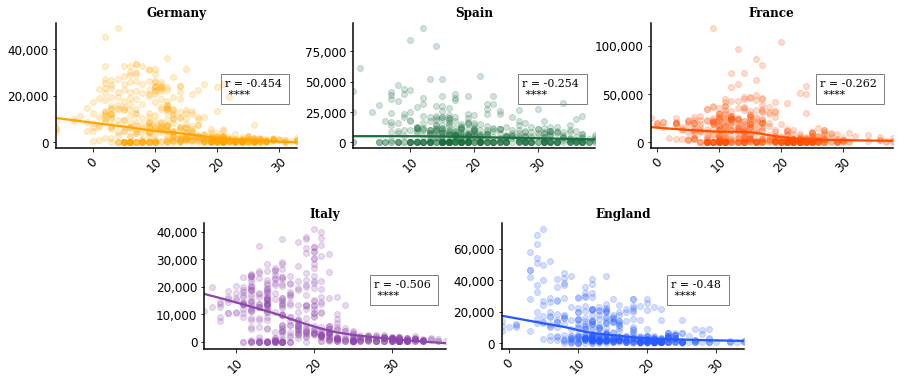

In [41]:
COL = 'tempC'

# Create Dataset
weather_cols = ['HeatIndexC', 'humidity', 'tempC', 'windspeedKmph', 'precipMM', 'DewPointC', 'pressure']
weather = data[['CountryName', 'NewCases'] + weather_cols]
corr_info = weather.groupby('CountryName').apply(lambda x: pearsonr(x.NewCases, x[COL]))


# Layout
fig, axes = plt.subplot_mosaic(
    """
    AABBCC
    .DDEE.
    """
    ,
    gridspec_kw = {'wspace': 0.6, 'hspace': 0.6},
    figsize=(15, 6)
)


unique_countries = data.CountryName.unique()
subplots_names = [*axes.keys()]

# Plot
for i, country in enumerate(unique_countries):
    # plot
    df_new = weather.loc[weather.CountryName == country]
    ax = axes[subplots_names[i]]
    color = color_dict[country]
    sns.regplot(data=df_new, y='NewCases', x=COL, ax=ax, ci=95, n_boot=50, lowess=True,
                line_kws={'color': color}, scatter_kws={'color': color, 'alpha': 0.2})
    
    r = corr_info[country][0]
    pvalue = _asteriks(corr_info[country][1])
    ax.annotate(f'r = {np.round(r, 3)} \n {pvalue}', size=11, fontfamily='serif', xycoords='axes fraction',
               xy=(0.7, 0.4), bbox=dict(facecolor='none', edgecolor='grey'))

    h, l = plot_formatter(ax, fig,
                           title=country, xlabel=None, ylabel=None,  
                           rotation=(45, 0), 
                           xlabel_size=16, ylabel_size=16, title_size=12,
                           xtick_size=12, ytick_size=12,
                           xlabel_pad=10, ylabel_pad=10,
                           title_position=(0.5, 1),
                           xaxis_lwd=1.5, yaxis_lwd=1.5,
                           xaxis_date=False, date_format='%b %Y', date_month_interval=4,
                           show_thousand_x=True, show_thousand_y=True,
                           remove_legend=False)
    

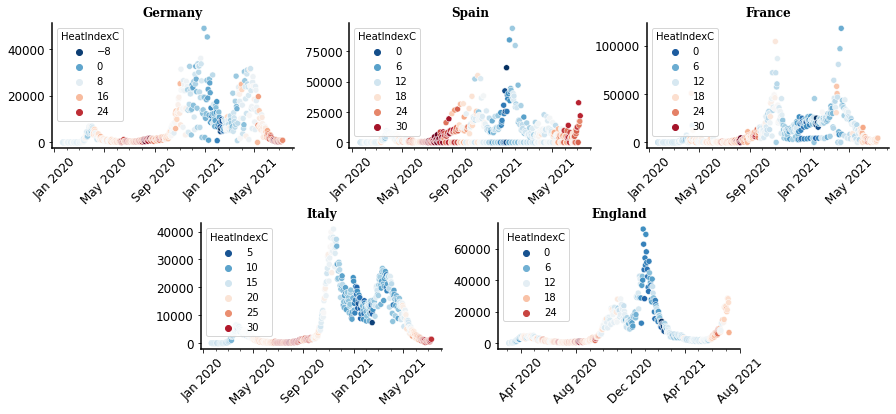

In [268]:
COL = 'HeatIndexC'

# Create Dataset
weather_cols = ['MaxTempC', 'MintempC', 'HeatIndexC', 'Humidity', 'TempC', 'WindSpeedKPH']
weather = data[['CountryName', 'NewCases'] + weather_cols]
cmap = matplotlib.cm.get_cmap(name='RdBu_r')


# Layout
fig, axes = plt.subplot_mosaic(
    """
    AABBCC
    .DDEE.
    """
    ,
    gridspec_kw = {'wspace': 0.6, 'hspace': 0.6},
    figsize=(15, 6)
)


unique_countries = data.CountryName.unique()
subplots_names = [*axes.keys()]

# Plot
for i, country in enumerate(unique_countries):
    # plot
    df_new = weather.loc[weather.CountryName == country]
    ax = axes[subplots_names[i]]
    color = color_dict[country]
    sns.scatterplot(data=df_new, x=df_new.index, y='NewCases', hue=COL, ax=ax, palette=cmap)
    

    h, l = plot_formatter(ax, fig,
                           title=country, xlabel=None, ylabel=None,  
                           rotation=(45, 0), 
                           xlabel_size=16, ylabel_size=16, title_size=12,
                           xtick_size=12, ytick_size=12,
                           xlabel_pad=10, ylabel_pad=10,
                           title_position=(0.5, 1),
                           xaxis_lwd=1.5, yaxis_lwd=1.5,
                           xaxis_date=True, date_format='%b %Y', date_month_interval=4,
                           show_thousand_x=False, show_thousand_y=False,
                           remove_legend=False)


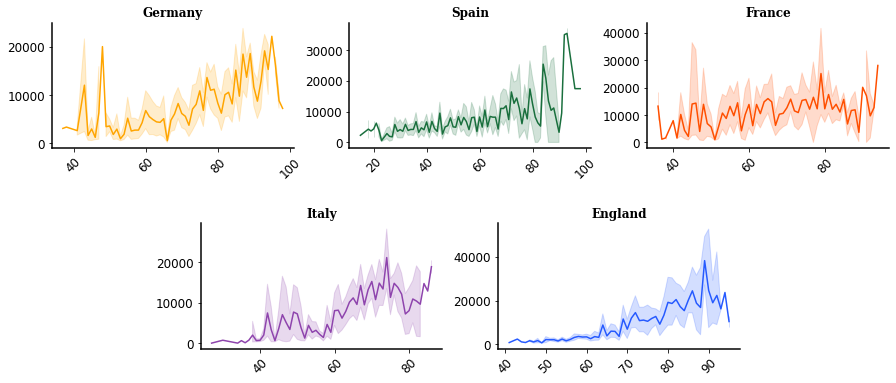

In [49]:
COL = 'humidity'

# Create Dataset
weather_cols = ['HeatIndexC', 'humidity', 'tempC', 'windspeedKmph', 'precipMM', 'DewPointC', 'pressure']
weather = data[['CountryName', 'SmoothNewCases'] + weather_cols]


# Layout
fig, axes = plt.subplot_mosaic(
    """
    AABBCC
    .DDEE.
    """
    ,
    gridspec_kw = {'wspace': 0.6, 'hspace': 0.6},
    figsize=(15, 6)
)


unique_countries = data.CountryName.unique()
subplots_names = [*axes.keys()]

# Plot
for i, country in enumerate(unique_countries):
    # plot
    df_new = weather.loc[weather.CountryName == country]
    ax = axes[subplots_names[i]]
    color = color_dict[country]
    sns.lineplot(data=df_new, y='SmoothNewCases', x=COL, ax=ax, ci=95, n_boot=5000,
                 color=color)
    

    h, l = plot_formatter(ax, fig,
                           title=country, xlabel=None, ylabel=None,  
                           rotation=(45, 0), 
                           xlabel_size=16, ylabel_size=16, title_size=12,
                           xtick_size=12, ytick_size=12,
                           xlabel_pad=10, ylabel_pad=10,
                           title_position=(0.5, 1),
                           xaxis_lwd=1.5, yaxis_lwd=1.5,
                           xaxis_date=False, date_format='%b %Y', date_month_interval=4,
                           show_thousand_x=False, show_thousand_y=False,
                           remove_legend=False)
    